In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import shap
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading data into a DataFrame
df = pd.read_csv('GDSI_OpenDataset_Final.csv')

In [3]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Applying imputation 
df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_encoded = encoder.fit_transform(df[categorical_cols])

encoded_features = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(categorical_encoded, columns=encoded_features)

# Combine the numeric and encoded categorical data 
cleaned_df = pd.concat([df[numeric_cols], encoded_df], axis=1)

In [4]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cleaned_df)

pca = PCA(n_components=0.95)  # retain 95% of the variance 
principal_components = pca.fit_transform(data_scaled)

# Create a DataFrame for the principal components 
pca_df = pd.DataFrame(data=principal_components, columns=[f"PC{i + 1}" for i in range(principal_components.shape[1])])

original_target = df['covid19_outcome_recovered']
filtered_target = original_target[original_target != 'not_applicable']
encoded_target = (filtered_target == 'yes').astype(int)

# Match the indices of the PCA DataFrame 
filtered_pca_df = pca_df.loc[filtered_target.index]

# Split the data into training and testing sets 
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    filtered_pca_df, encoded_target, test_size=0.2, random_state=42
)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_filtered, y_train_filtered)

In [5]:
# Apply SMOTE for handling imbalanced classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Define models and parameter grids for hyperparameter tuning
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network (MLPClassifier)": MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier()
}

param_grids = {
    "Logistic Regression": {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga']},
    "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    "Support Vector Machine": {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    "K-Nearest Neighbors": {'n_neighbors': [3, 5, 7]},
    "Neural Network (MLPClassifier)": {'hidden_layer_sizes': [(50,), (100,), (100, 50)]},
    "XGBoost": {'n_estimators': [50, 100, 200]},
    "LightGBM": {'num_leaves': [31, 63, 127]}
}

# Hyperparameter tuning using GridSearchCV
for model_name, param_grid in param_grids.items():
    model = models[model_name]
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_balanced, y_train_balanced)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validated score: {grid_search.best_score_:.4f}")

Best parameters for Logistic Regression: {'C': 0.1, 'solver': 'saga'}
Best cross-validated score: 0.9542
Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 100}
Best cross-validated score: 0.9667
Best parameters for Support Vector Machine: {'C': 0.01, 'kernel': 'linear'}
Best cross-validated score: 0.9708
Best parameters for K-Nearest Neighbors: {'n_neighbors': 3}
Best cross-validated score: 0.5667
Best parameters for Neural Network (MLPClassifier): {'hidden_layer_sizes': (100,)}
Best cross-validated score: 0.6208
Best parameters for XGBoost: {'n_estimators': 50}
Best cross-validated score: 0.9333
[LightGBM] [Info] Number of positive: 96, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69486
[LightGBM] [Info] Number of data points in the train set: 192, number of used features: 1064
[LightGBM] [Info] [bin

Logistic Regression Accuracy: 0.98
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.97      1.00      0.99        36

    accuracy                           0.98        50
   macro avg       0.99      0.96      0.97        50
weighted avg       0.98      0.98      0.98        50


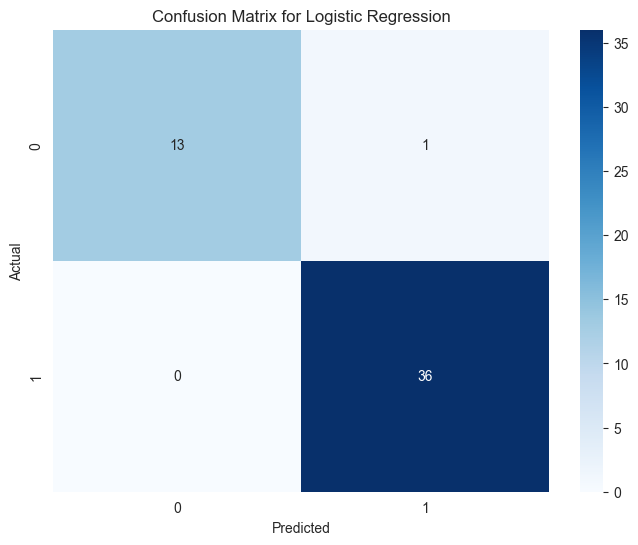

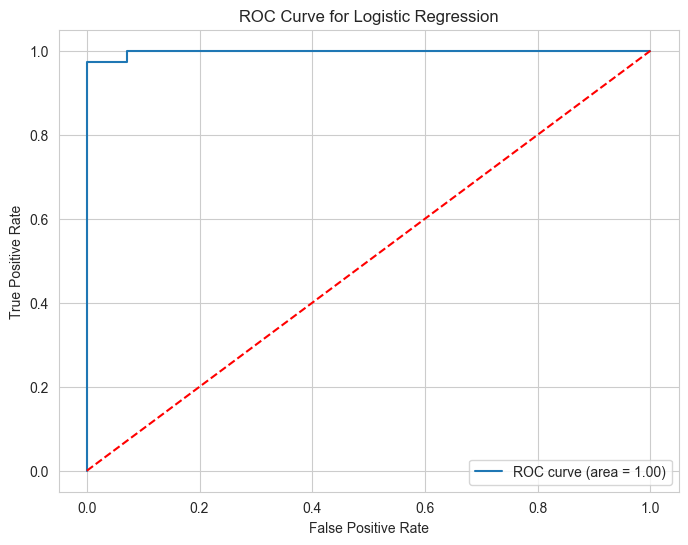

Random Forest Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        36

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50


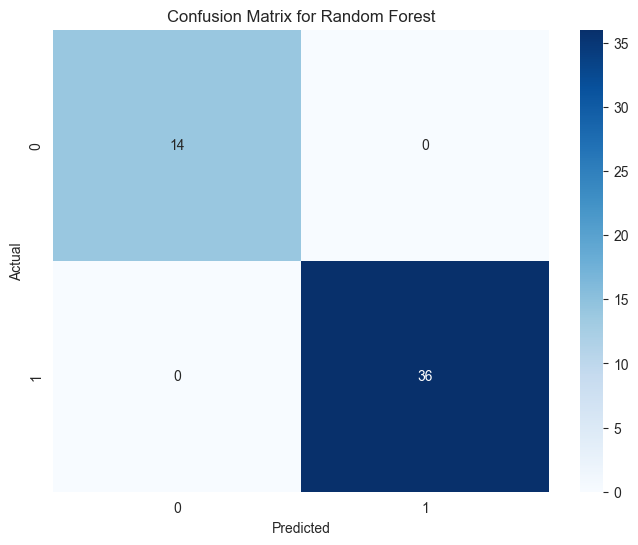

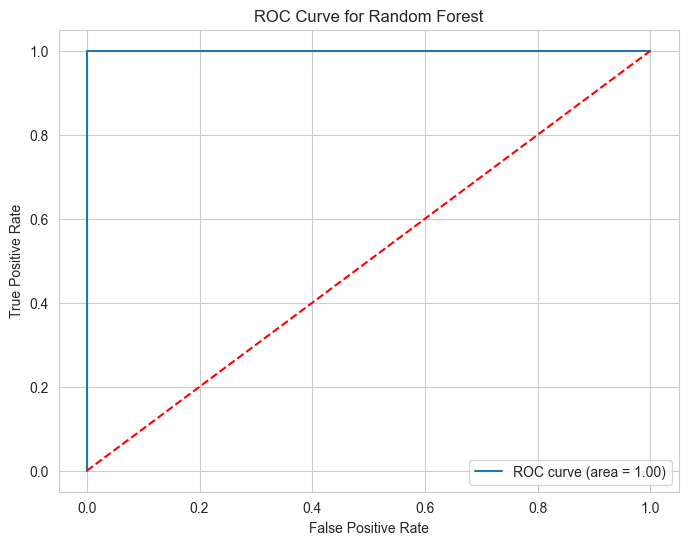

Support Vector Machine Accuracy: 0.90
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        14
           1       0.88      1.00      0.94        36

    accuracy                           0.90        50
   macro avg       0.94      0.82      0.86        50
weighted avg       0.91      0.90      0.89        50


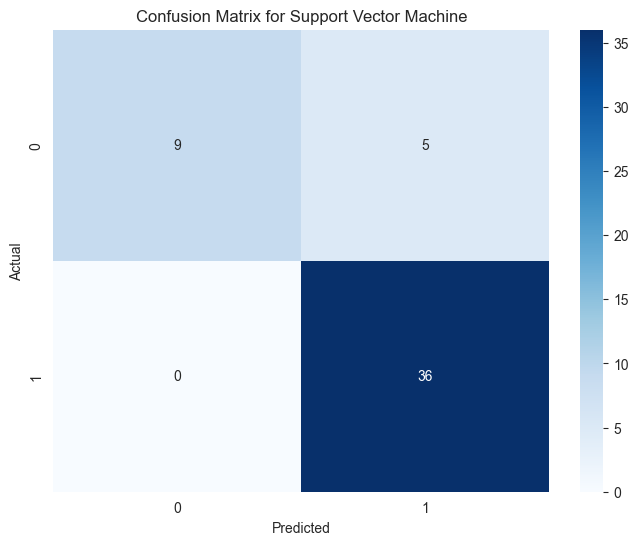

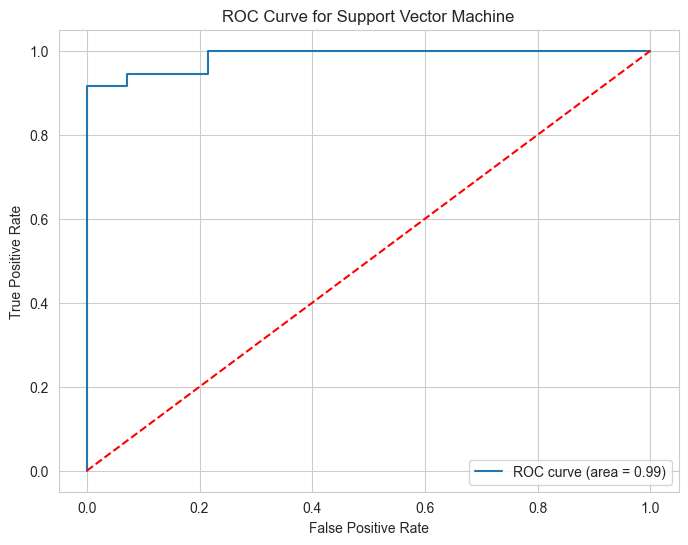

C:\Users\DELL\Desktop\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\Desktop\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\Desktop\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

K-Nearest Neighbors Accuracy: 0.28
              precision    recall  f1-score   support

           0       0.28      1.00      0.44        14
           1       0.00      0.00      0.00        36

    accuracy                           0.28        50
   macro avg       0.14      0.50      0.22        50
weighted avg       0.08      0.28      0.12        50


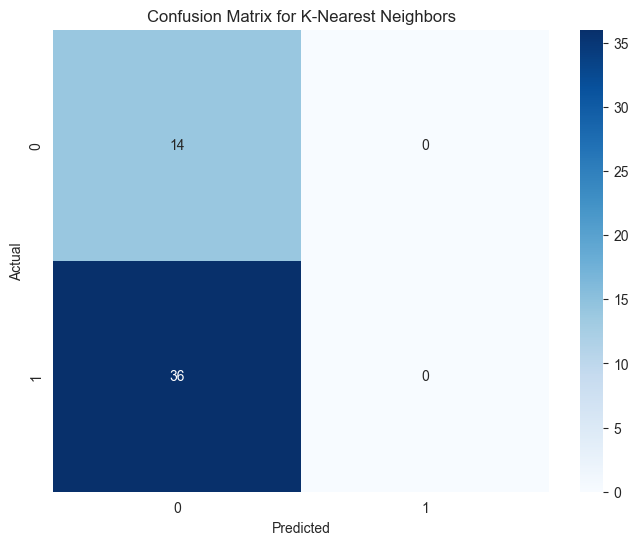

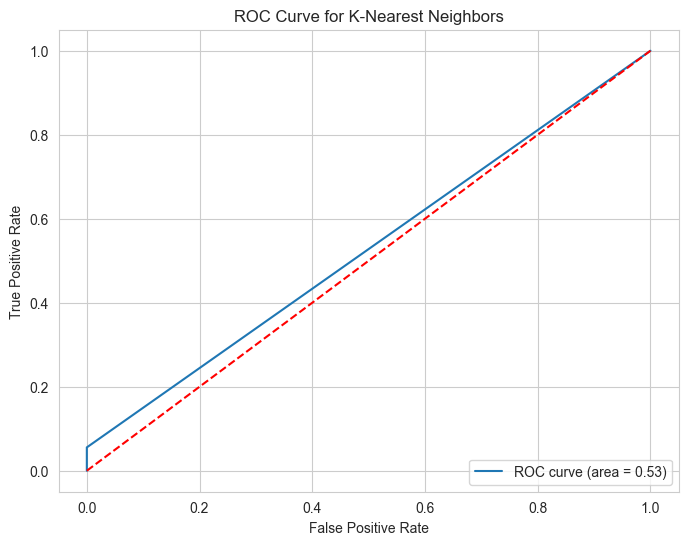

Naive Bayes Accuracy: 0.60
              precision    recall  f1-score   support

           0       0.39      0.79      0.52        14
           1       0.86      0.53      0.66        36

    accuracy                           0.60        50
   macro avg       0.63      0.66      0.59        50
weighted avg       0.73      0.60      0.62        50


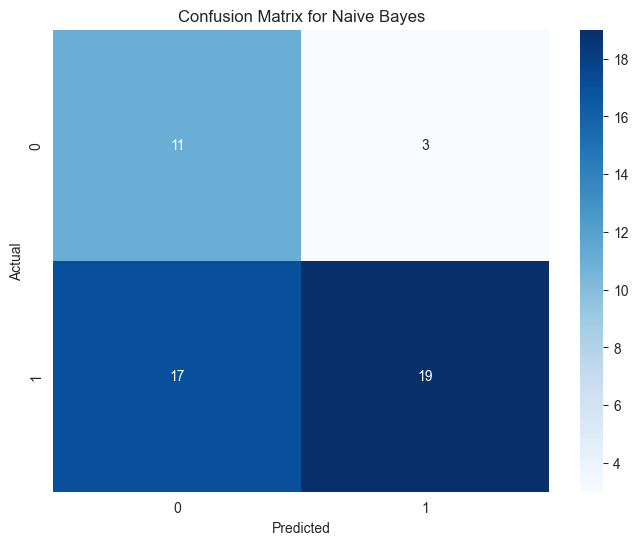

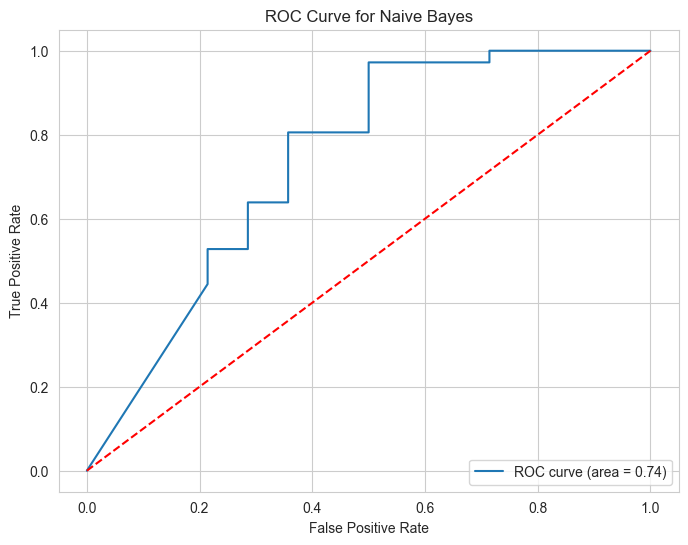

Neural Network (MLPClassifier) Accuracy: 0.22
              precision    recall  f1-score   support

           0       0.12      0.29      0.17        14
           1       0.41      0.19      0.26        36

    accuracy                           0.22        50
   macro avg       0.27      0.24      0.22        50
weighted avg       0.33      0.22      0.24        50


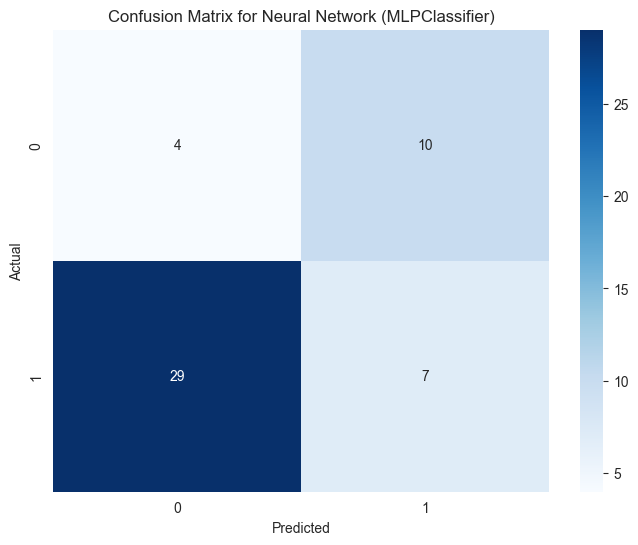

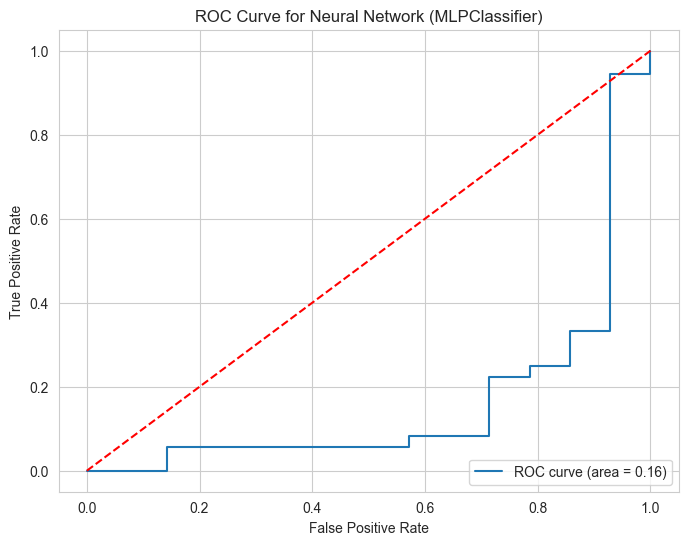

XGBoost Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       1.00      0.94      0.97        36

    accuracy                           0.96        50
   macro avg       0.94      0.97      0.95        50
weighted avg       0.96      0.96      0.96        50


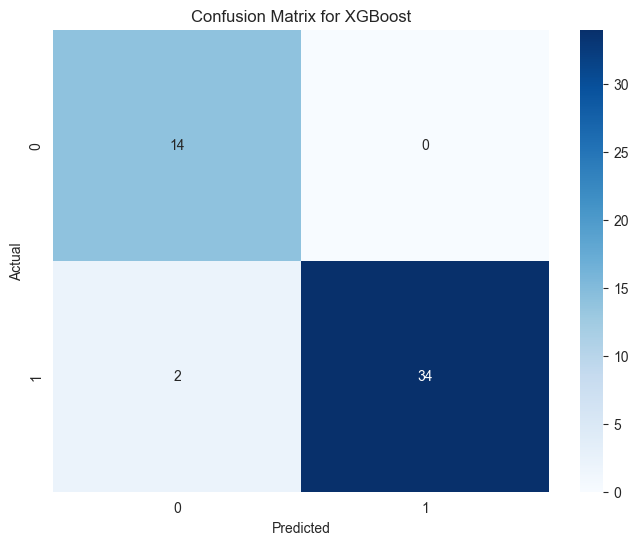

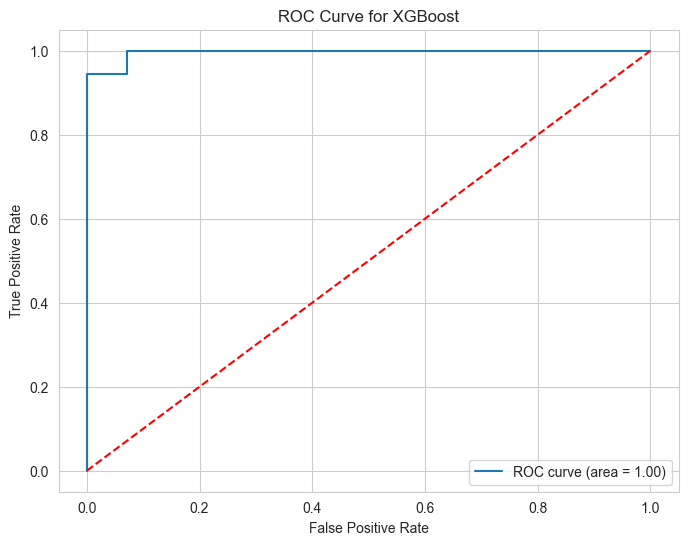

[LightGBM] [Info] Number of positive: 120, number of negative: 120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86462
[LightGBM] [Info] Number of data points in the train set: 240, number of used features: 1064
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

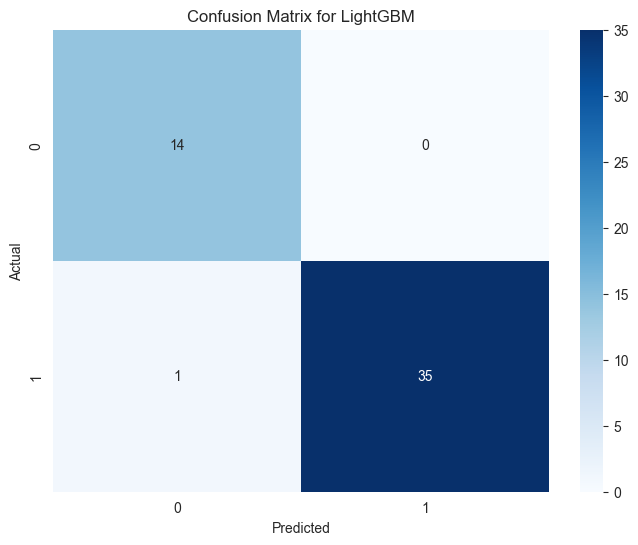

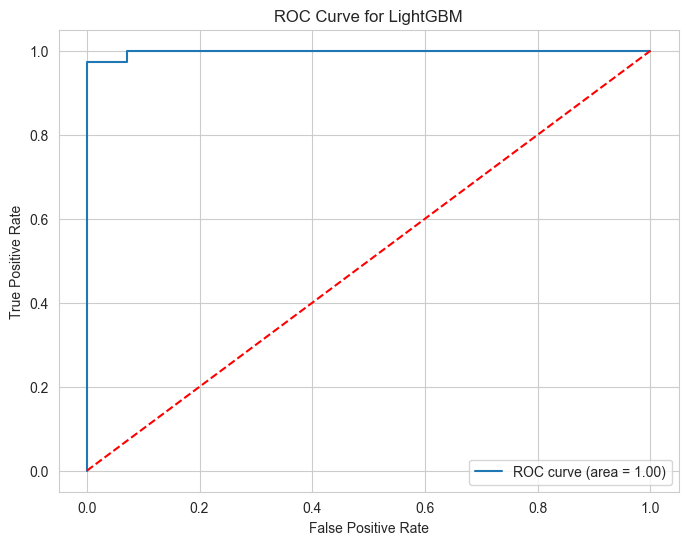

In [6]:
# Evaluate models
for model_name, model in models.items():
    # Train model on balanced training set
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_filtered)

    # Accuracy and classification report
    accuracy = accuracy_score(y_test_filtered, y_pred)
    class_report = classification_report(y_test_filtered, y_pred)

    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(class_report)

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test_filtered, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_filtered)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_filtered, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.title(f'ROC Curve for {model_name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

Logistic Regression - Training Accuracy: 1.00, Test Accuracy: 0.98
Random Forest - Training Accuracy: 1.00, Test Accuracy: 0.98
Support Vector Machine - Training Accuracy: 1.00, Test Accuracy: 0.90
K-Nearest Neighbors - Training Accuracy: 0.53, Test Accuracy: 0.28
Naive Bayes - Training Accuracy: 0.76, Test Accuracy: 0.60
Neural Network (MLPClassifier) - Training Accuracy: 0.95, Test Accuracy: 0.44
XGBoost - Training Accuracy: 1.00, Test Accuracy: 0.96
[LightGBM] [Info] Number of positive: 120, number of negative: 120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86462
[LightGBM] [Info] Number of data points in the train set: 240, number of used features: 1064
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

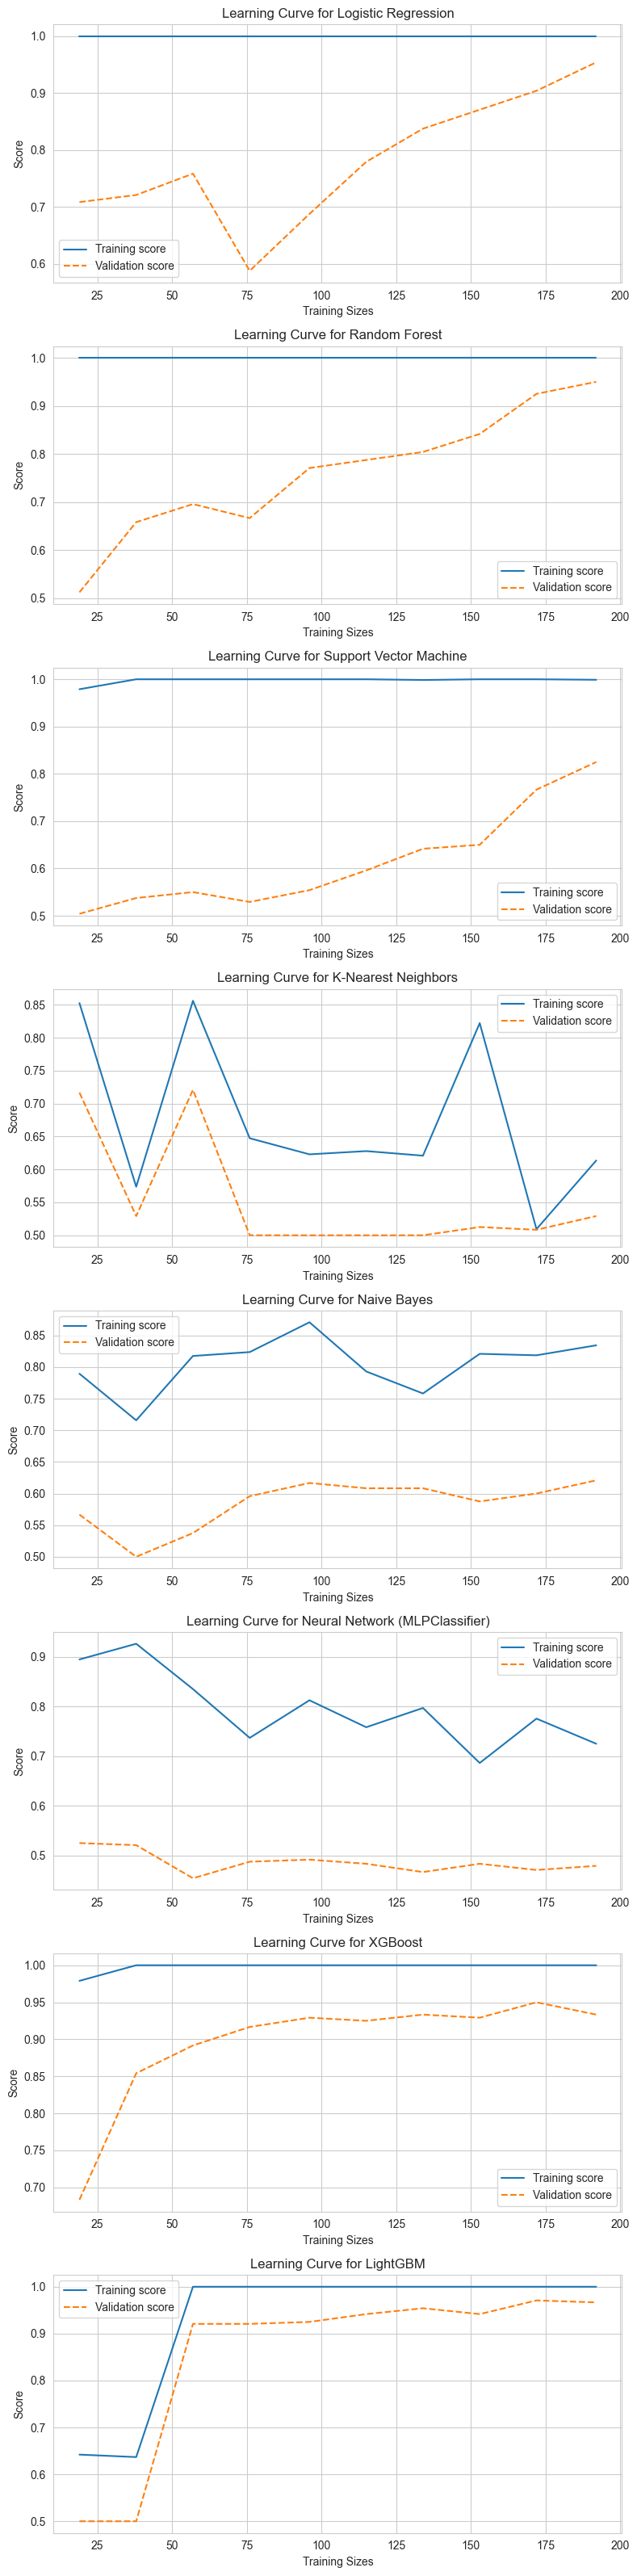

In [7]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Set up the number of rows and columns based on the number of models
num_models = len(models)
fig, axes = plt.subplots(num_models, 1, figsize=(8, 4 * num_models))

# Loop over models and axes
for ax, (model_name, model) in zip(axes, models.items()):
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test_filtered, y_test_filtered)

    print(f"{model_name} - Training Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")

    # Calculate learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    # Plot learning curve for the current model in the corresponding subplot
    ax.plot(train_sizes, train_scores_mean, label="Training score")
    ax.plot(train_sizes, test_scores_mean, '--', label="Validation score")
    ax.set_title(f'Learning Curve for {model_name}')
    ax.set_xlabel('Training Sizes')
    ax.set_ylabel('Score')
    ax.legend(loc='best')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined image with all subplots
plt.show()


In [8]:
# Create a list to store model predictions and probabilities
results = []

# Iterate through the models and store results
for model_name, model in models.items():
    #predicted_outcome = model.predict(new_data_point_df)
    #predicted_probability = model.predict_proba(new_data_point_df)
    
    outcome_mapping = {0: "no", 1: "yes"}
    #predicted_outcome_str = outcome_mapping[predicted_outcome[0]]
    
    # Append the results to the list (model name, predicted outcome, and probabilities)
    #results.append({
        #"Model": model_name,
       # "Predicted Outcome": predicted_outcome_str,
       # "Probability (no)": predicted_probability[0][0],
       # "Probability (yes)": predicted_probability[0][1]
    #})

#results_df = pd.DataFrame(results)

# Format the probabilities to 3 decimal places for better readability
#results_df['Probability (no)'] = results_df['Probability (no)'].round(3)
#results_df['Probability (yes)'] = results_df['Probability (yes)'].round(3)

# Display the table
#print(results_df)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate fairness across demographic groups
def evaluate_fairness(y_true, y_pred, demographic_col):
    # Convert inputs to Series if they are numpy arrays
    if isinstance(y_true, np.ndarray):
        y_true = pd.Series(y_true, index=demographic_col.index)
    if isinstance(y_pred, np.ndarray):
        y_pred = pd.Series(y_pred, index=demographic_col.index)

    demographic_groups = demographic_col.unique()
    results = {}

    for group in demographic_groups:
        # Create a mask for the current demographic group
        group_mask = demographic_col == group
        
        # Extract true and predicted values for this group using the mask
        group_y_true = y_true[group_mask]
        group_y_pred = y_pred[group_mask]

        # Check if both arrays have values to avoid empty group error
        if not group_y_true.empty and not group_y_pred.empty:
            # Calculate the metrics
            accuracy = accuracy_score(group_y_true, group_y_pred)
            precision = precision_score(group_y_true, group_y_pred, zero_division=0)
            recall = recall_score(group_y_true, group_y_pred, zero_division=0)
            f1 = f1_score(group_y_true, group_y_pred, zero_division=0)

            # Store the results
            results[group] = {
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1
            }
        else:
            print(f"No data for group: {group}")

    return results

# List of demographic columns to evaluate
demographic_columns = ['age_in_cat', 'bmi_in_cat2', 'sex', 'has_comorbidities']  # Add more as needed

# Assuming you have your predictions (y_pred) and true labels (y_true)
y_pred_filtered = model.predict(X_test_filtered)  # Example model prediction
y_pred_filtered = pd.Series(y_pred_filtered, index=y_test_filtered.index)

# Loop through each demographic column and evaluate fairness
for demographic_col in demographic_columns:
    fairness_results = evaluate_fairness(y_test_filtered, y_pred_filtered, df[demographic_col])

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(fairness_results).T  # Transpose to have groups as rows
    results_df.reset_index(inplace=True)  # Reset index to have group names as a column
    results_df.rename(columns={'index': demographic_col}, inplace=True)

    # Visualization
    plt.figure(figsize=(12, 8))
    results_df.set_index(demographic_col).plot(kind='bar', ax=plt.gca())
    plt.title(f'Model Performance Metrics by {demographic_col.capitalize()}')
    plt.ylabel('Scores')
    plt.xticks(rotation=45)
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()